In [1]:
import matplotlib.pyplot as plt
import torch
import gpytorch

from botorch.models import ModelListGP
from botorch.optim import optimize_acqf
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
import numpy as np
from alse.eci import ExpectedCoverageImprovement
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints
from alse.fit_model import fit_gp_class, fit_gp_reg
from alse.test_function.fxns import yf, hills, circle
from alse.fit_all_demo_only import fit_all_models
from alse.plot_demo import plot_3_graphs, side_by_side, make_meshgrid
# from mpl_toolkits import mplot3d
# from matplotlib import cm

In [2]:
torch.cuda.is_available()

True

If no GPU change "cuda" to "cpu"

In [3]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
}

In [4]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

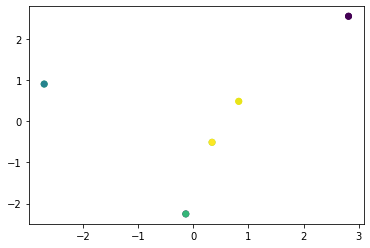

In [5]:
num_init_points = 5
num_total_points = 20
X = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
Yhills = hills(X)
Ycircle = circle(X)
Yyf = yf(X)
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=Yhills.cpu()[:,0])
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=Ycircle.cpu()[:,0])

In [6]:
gp_model_hills = fit_gp_reg(X, Yhills)
gp_model_circle = fit_gp_reg(X, Ycircle)
gp_model_class = fit_gp_class(X, Yyf, iter=300, lr=0.05)
model_list_gp = ModelListGP(gp_model_hills, gp_model_circle, gp_model_class)

c:\Program Files\Python310\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [7]:
constraints = [("gt", 0.3), ("gt", 20), ("gt", 0.1)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std
i = 1
while len(X) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    gp_model_hills = fit_gp_reg(X, Yhills)
    gp_model_circle = fit_gp_reg(X, Ycircle)
    gp_model_class = fit_gp_class(X, Yyf, iter=300, lr=0.05)
    model_list_gp = ModelListGP(gp_model_hills, gp_model_circle, gp_model_class)

    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512,
    )
    gp_model_hills.eval()
    gp_model_circle.eval()
    gp_model_class.eval()

    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )

    print(f"New X No. {i}")
    i += 1
    X = torch.cat((X, x_next))
    Yhills = torch.cat((Yhills, hills(x_next)))
    Ycircle = torch.cat((Ycircle, circle(x_next)))
    Yyf = torch.cat((Yyf, yf(x_next)))

c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


New X No. 1


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 2


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 3


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


New X No. 4


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


New X No. 5


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


New X No. 6


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 7


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 8


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 9


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 10


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 11


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 12


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 13


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 14


c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X No. 15


In [8]:
'''
Decrease N if not enough memory
'''
N1, N2 = 150, 150
Xplt, Yplt, xplt = make_meshgrid(N1, N2, tkwargs)

c:\Program Files\Python310\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
yplt_hills = hills(xplt)
Zplt_hills = torch.reshape(yplt_hills[:, 0], (N1, N2)) 

feasible_inds_hills = (
    identify_samples_which_satisfy_constraints(Yhills, constraints[0])
    .prod(dim=-1)
    .to(torch.bool)
)

In [10]:
yplt_circle = circle(xplt)
Zplt_circle = torch.reshape(yplt_circle[:, 0], (N1, N2)) 

feasible_inds_circle = (
    identify_samples_which_satisfy_constraints(Ycircle, constraints[1])
    .prod(dim=-1)
    .to(torch.bool)
)

In [11]:
yplt_yf = yf(xplt)
Zplt_yf = torch.reshape(yplt_yf[:, 0], (N1, N2)) 

feasible_inds_yf = (
    identify_samples_which_satisfy_constraints(Yyf, constraints[2])
    .prod(dim=-1)
    .to(torch.bool)
)

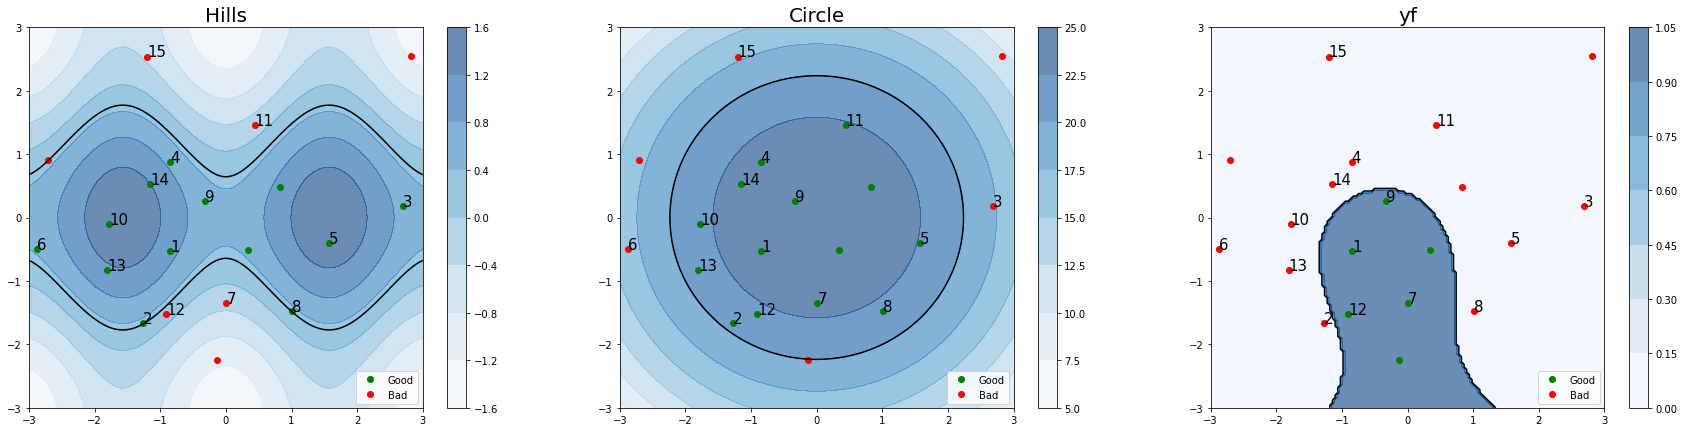

In [12]:
plot_3_graphs(X, [feasible_inds_hills, feasible_inds_circle, feasible_inds_yf], Xplt, Yplt, [Zplt_hills, Zplt_circle, Zplt_yf,], ["Hills", "Circle", "yf"], constraints)

Calculate Posterior and plot

In [13]:
pos_Zplt_hills, pos_Zplt_circle, pos_Zplt_yf = fit_all_models(xplt, N1, N2, X, Yhills, Ycircle, Yyf)

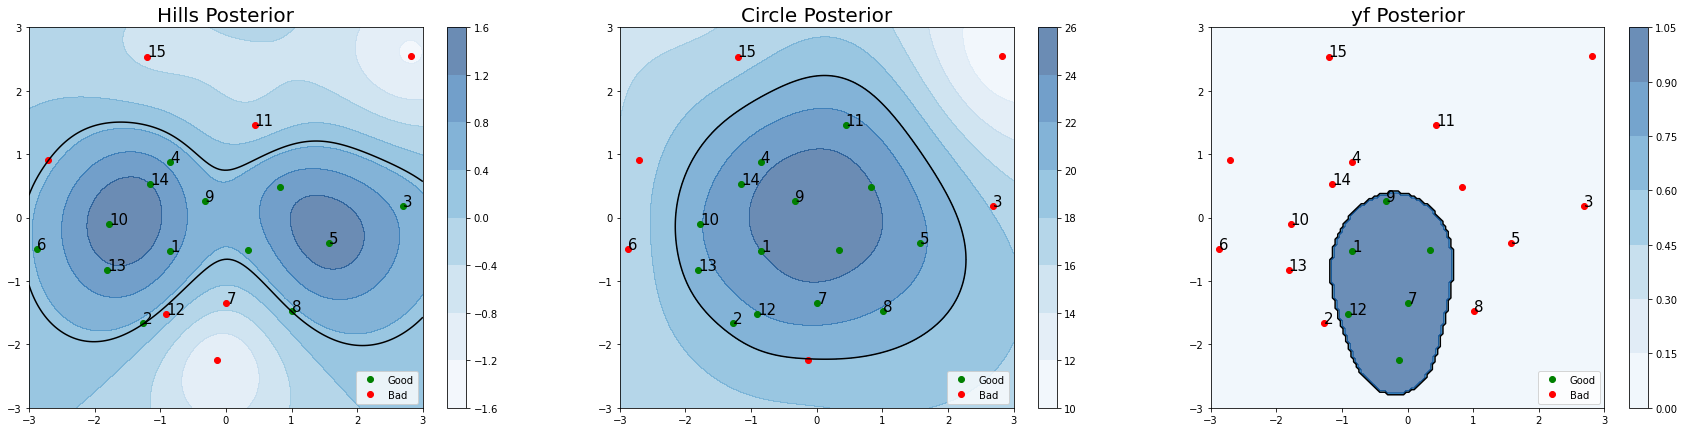

In [14]:
plot_3_graphs(X, [feasible_inds_hills, feasible_inds_circle, feasible_inds_yf], 
              Xplt, Yplt, [pos_Zplt_hills, pos_Zplt_circle, pos_Zplt_yf], 
              ["Hills Posterior", "Circle Posterior", "yf Posterior"], constraints)

In [16]:
pos_yplt_hills = gp_model_hills(xplt).loc
pos_yplt_circle = gp_model_circle(xplt).loc

pos_Zplt_hills = pos_yplt_hills.reshape(N1, N2)
pos_Zplt_circle = pos_yplt_circle.reshape(N1, N2)

pos_yplt_yf = gp_model_class(xplt.float())
pred_means = pos_yplt_yf.loc
pred_samples = pos_yplt_yf.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities[0] = (probabilities[0]-probabilities[0].min())/(probabilities[0].max()-probabilities[0].min())
probabilities[1] = (probabilities[1]-probabilities[1].min())/(probabilities[1].max()-probabilities[1].min())
pos_Zplt_yf = probabilities.max(0)[1].reshape((N1,N2))

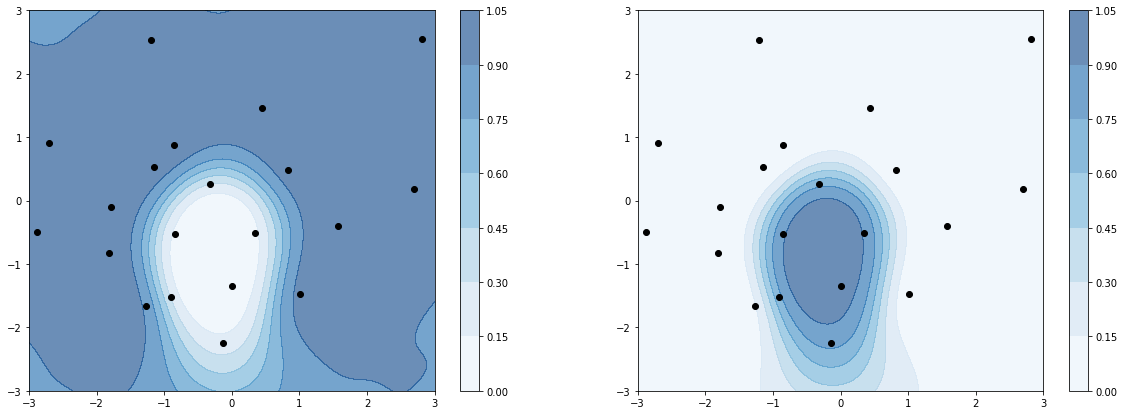

In [17]:
# No title and no color points
side_by_side(X, Xplt, Yplt, probabilities, N1, N2) 

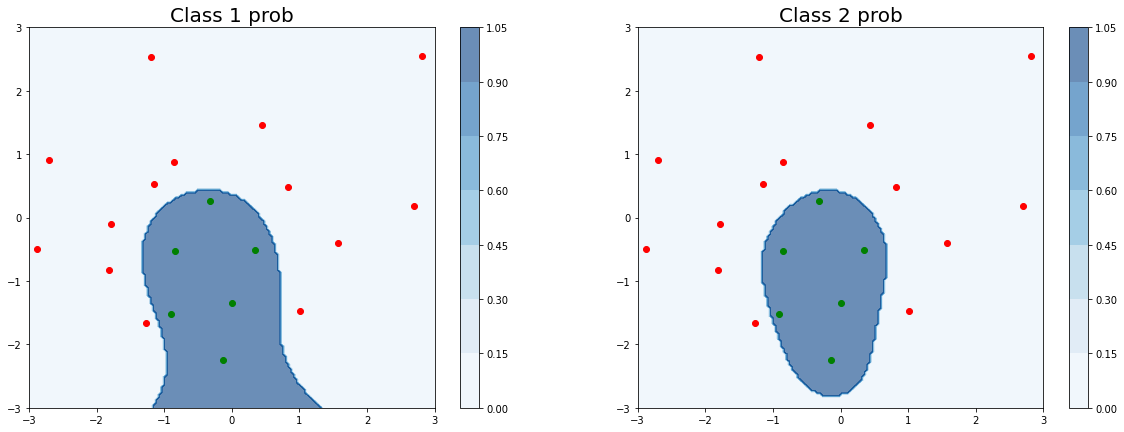

In [18]:
# With title and color points
side_by_side(X, Xplt, Yplt, [Zplt_yf, pos_Zplt_yf], N1, N2, ["Class 1 prob", "Class 2 prob"], feasible_inds=feasible_inds_yf) 

In [19]:
# Calculate true overlap region
true_overlap = (Zplt_hills > 0.3) & (Zplt_circle > 20) & (Zplt_yf > 0)
pos_overlap = (pos_Zplt_hills > 0.3) & (pos_Zplt_circle > 20) & (pos_Zplt_yf > 0)
true_overlap_points = feasible_inds_circle & feasible_inds_hills & feasible_inds_yf

# Make list of boundaries to plot
true_bound = [(Zplt_hills>0.3), (Zplt_circle>20), Zplt_yf]
est_bound = [(pos_Zplt_hills>0.3), (pos_Zplt_circle>20), pos_Zplt_yf]

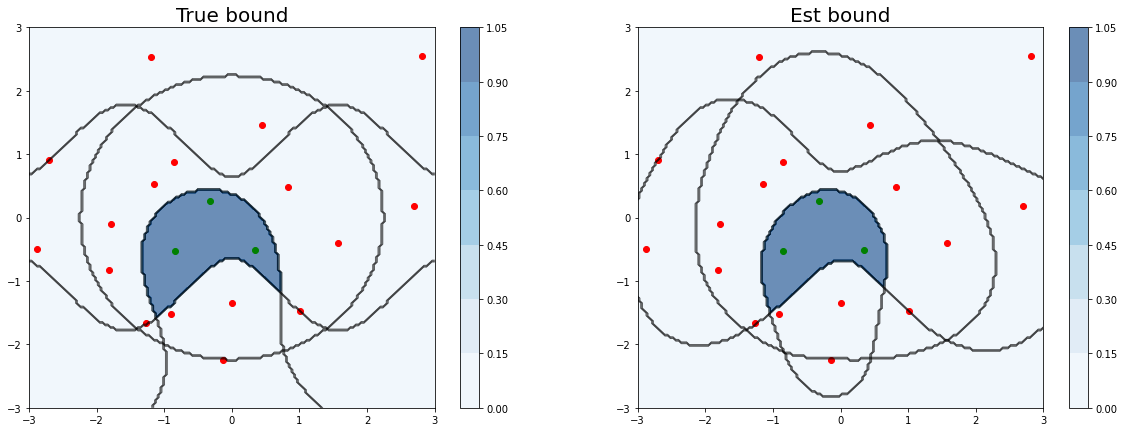

In [20]:
side_by_side(X, Xplt, Yplt, [true_overlap, pos_overlap], N1, N2, ["True bound", "Est bound"], 
             feasible_inds=true_overlap_points, boundary=[true_bound, est_bound])

In [21]:
get_accuracy(pos_overlap, true_overlap)

Accuracy of this run: 0.7979,
 Reward: 1255 
 Penalty: 67


In [22]:
# if torch.cuda.is_available():
#     import gc
#     import torch
#     gc.collect()
#     torch.cuda.empty_cache()